# Housing Price Prediction 
https://www.kaggle.com/c/house-prices-advanced-regression-techniques
Regression Problem
Applied Linear Regression, Lasso Regression, Ridge Regression, Random Forest, and XGBoost.  

Steps:

1. Data Cleaning, drop the feature if more than 95% of the feature values are NANs, 0, or no variance. 

2. Fill in the missing data. If categorical variable, fill in ‘None’. If numeric variable, fill in “0” or median depending on the case. 

3. Label encoding. Categorical variable has to be converted to numeric values in the preprocessing. If ordinal variable (e.g., ‘Ex’,’Gd’,’Ta’,’Fa’,’Po’), use label encoder. For nominal variable (e.g., ‘male’, ‘female’), use one-hot encoding to create dummy variables. 

4. Feature selection. Assuming the linear relationship, checked the statistic p_value (adjusted R^2 value). Use Lasso Regression for the feature selection (because the coefficient can be zeros, means no contribution to the model). 

5. Modeling. Ridge/Lasso Regression works the best. 

In [1]:
import pandas as pd
%matplotlib inline
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns 
from house_functions import * # self-defined 

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [3]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso,LassoCV
import statsmodels.api as sm
from scipy import stats

In [4]:
train = pd.read_csv('train.csv') 
test = pd.read_csv('test.csv')
print('Length of trainning', len(train))
print('Length of test', len(test))

Length of trainning 1460
Length of test 1459


In [5]:
# combine train and test data 
data=pd.concat([train,test], axis=0,sort=False).reset_index(drop=True) 
# combine training and test 
print('Total Data Shape',data.shape)

Total Data Shape (2919, 81)


In [6]:
# drop if too many NaNs (>95%)
nan=pd.isnull(data).sum().sort_values(ascending=False).head(2)
dropcol=[]
for col in nan.axes[0]:
    dropcol.append(col)

for col in data.columns:   # if too many zeros
    if data[col].dtype==np.int64:
        if (data[col]==0).sum() >=2919*0.95:
            print((data[col]==0).sum(),col)
            dropcol.append(col)
for col in data.columns:
    if data[col].dtypes == np.object:
        a=data.groupby(col).count()
        #print(a.Id.max())
        if a.Id.max()>=2919*0.95:  # which means 90% of the information are the same 
            print(a.Id.max(),col)
            dropcol.append(col)

2879 LowQualFinSF
2882 3SsnPorch
2906 PoolArea
2816 MiscVal
2907 Street
2916 Utilities
2778 LandSlope
2889 Condition2
2876 RoofMatl
2874 Heating


In [7]:
dropcol.append('Id')
data_clean=data.drop(columns=dropcol,axis=1)
print('data size after clean', data_clean.shape)

data size after clean (2919, 68)


In [8]:
numeric_features = data_clean.select_dtypes(include=[np.number])
categorical_features = data_clean.select_dtypes(include=[np.object])

In [9]:
N=pd.isnull(data_clean).sum().sort_values(ascending=False).head(30) 
# all the features that have NaNs

In [10]:
print([x for x in N.axes[0] if x in numeric_features.columns])

['SalePrice', 'LotFrontage', 'GarageYrBlt', 'MasVnrArea', 'BsmtHalfBath', 'BsmtFullBath', 'GarageCars', 'GarageArea', 'BsmtFinSF2', 'BsmtFinSF1', 'BsmtUnfSF']


### Fill in the missing data and encode catergory data
Catergorical Data Types: ordinal & nominal; for ordinal type, use label encoded. 


In [11]:
# Category features fill in the missing data 
for col in categorical_features.columns:
    data_clean[col]=data_clean[col].fillna('None')
    
# Numeric features        
for col in ('GarageYrBlt','MasVnrArea','BsmtHalfBath','BsmtFullBath','GarageCars',\
            'GarageArea','BsmtFinSF2','BsmtFinSF1','BsmtUnfSF','TotalBsmtSF'):
    data_clean[col] = data_clean[col].fillna(0)   

#col=data.columns
data_clean.GarageYrBlt.fillna(2100,inplace=True)
data_clean["LotFrontage"] = data_clean.groupby("Neighborhood")["LotFrontage"].transform(\
    lambda x: x.fillna(x.median()))

In [12]:
# select ordinal data 
#for c in categorical_features.columns:
#    print(c, ':', data_clean[c].unique())

In [13]:
ordinal_c=['ExterQual','ExterCond','HeatingQC','KitchenQual','FireplaceQu',\
           'GarageQual','GarageCond','GarageFinish',\
          'BsmtExposure','BsmtCond','BsmtQual']

In [14]:
from sklearn import preprocessing 
codes = {'Gd':4,'TA':3,'Ex':5,'Fa':2,'Po':1,'None':0}
for col in ['ExterQual','ExterCond','HeatingQC','FireplaceQu','KitchenQual']:
    data_clean[col] = data_clean[col].map(codes)

In [15]:
# continue
codes = {'Ex':5,'Gd':4, 'TA':3, 'Fa':2,'Po':1,'None':0}
data_clean['BsmtQual'] = data_clean['BsmtQual'].map(codes)
data_clean['BsmtCond'] = data_clean['BsmtCond'].map(codes)

codes = {'Ex':5,'Gd':4, 'TA':3, 'Fa':2,'Po':1,'None':0}
data_clean['GarageQual'] = data_clean['GarageQual'].map(codes)
data_clean['GarageCond'] = data_clean['GarageCond'].map(codes)

codes = {'Gd':4, 'Av':3, 'Mn':2, 'No':1,'None':0}
data_clean['BsmtExposure'] = data_clean['BsmtExposure'].map(codes)

codes = {'Fin':3,'RFn':2,'Unf':1,'None':0}
data_clean['GarageFinish'] = data_clean['GarageFinish'].map(codes)

In [16]:
# get the dummy 
dummy=list(set(categorical_features.columns)-set(ordinal_c))
data_dummy = pd.get_dummies(data_clean, columns=dummy)

In [17]:
data_dummy.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,...,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,MSZoning_C (all),MSZoning_FV,MSZoning_None,MSZoning_RH,MSZoning_RL,MSZoning_RM
0,60,65.0,8450,7,5,2003,2003,196.0,4,3,...,0,0,0,0,0,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,3,3,...,0,0,0,0,0,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,4,3,...,0,0,0,0,0,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,3,3,...,0,0,0,0,0,0,0,0,1,0
4,60,84.0,14260,8,5,2000,2000,350.0,4,3,...,0,0,0,0,0,0,0,0,1,0


In [18]:
#pd.isnull(data_dummy).sum().sort_values(ascending=False).head(4)

Now the data has 223 columns. 

## Check the skewness 

why? because in linear regression, y = beta*x + eps; we assume eps is Normal Distribution, linearity -- y Normal Distribution 


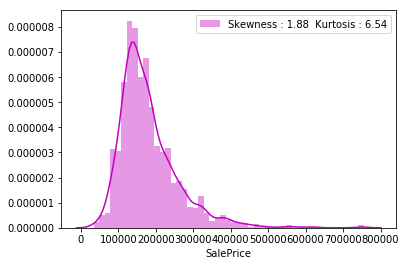

In [19]:
g = sns.distplot(train['SalePrice'], color="m", label="Skewness : %.2f  Kurtosis : %.2f"\
                %(train['SalePrice'].skew(), train['SalePrice'].kurt()))
g = g.legend(loc="best")

In [20]:
# Check the skew of all numerical features 
# Does it matter? Yes. 
from scipy.stats import norm, skew
skewed_feats = data_dummy[numeric_features.columns].drop(columns=['SalePrice']).\
                                     apply(lambda x: skew(x)).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(5)

,Skew
LotArea,12.822431
KitchenAbvGr,4.302254
BsmtFinSF2,4.146143
EnclosedPorch,4.003891
ScreenPorch,3.946694


In [21]:
skewness = skewness[abs(skewness) > 1.0]
skewed_features = skewness.index
lam = 0.25
from scipy.special import boxcox1p
for col in skewed_features:
    data_dummy[col] = boxcox1p(data_dummy[col], lam)

### Standardization (or Z-score normalization)

In [22]:
# remove two outliers 
#train_std.head()
#data_dummy=data_dummy.drop(data_dummy.index[[523,1298]],axis=0)
#data_loc.drop(data.index[[523,1298]], inplace=True,axis=0)

In [23]:
train_dummy=data_dummy[:(len(train))]

train_X = train_dummy.drop(columns=['SalePrice'])
train_y = train_dummy['SalePrice'] 
train_y = np.log1p(train_y)

num_features = data_clean.drop(columns=['SalePrice']).select_dtypes(include=[np.number])
#print(num_features.columns)

In [24]:
# feature normalization 
xscaler = StandardScaler()
yscaler = StandardScaler()

train_X_std=train_X.copy()
train_y_std=train_y.copy()

train_X_std[num_features.columns] = (xscaler.fit_transform(train_X[num_features.columns]))
train_y_std = yscaler.fit_transform(train_y.values.reshape((len(train_y), 1))) # series data 

In [25]:
# test data 
test_dummy=data_dummy[(len(train)):]
test_X = test_dummy.drop(columns=['SalePrice'])
test_X_std=test_X.copy()
test_X_std[num_features.columns] = xscaler.transform(test_X[num_features.columns])

In [26]:
y=pd.DataFrame(train_y_std,columns=['SalePrice'])['SalePrice']
X=train_X_std
print('Training Set', X.shape, y.shape) 

Training Set (1460, 222) (1460,)


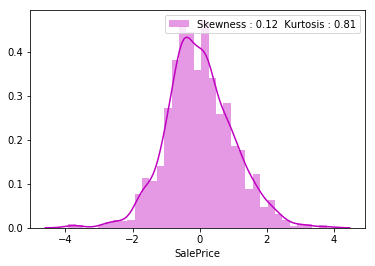

In [27]:
g = sns.distplot(y, color="m", label="Skewness : %.2f  Kurtosis : %.2f"\
                %(y.skew(), y.kurt()))
g = g.legend(loc="best")

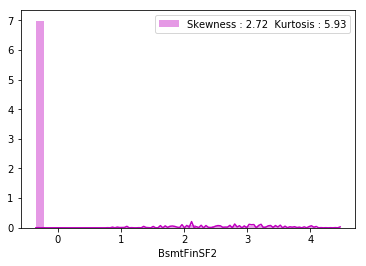

In [28]:
g = sns.distplot(X['BsmtFinSF2'], color="m", label="Skewness : %.2f  Kurtosis : %.2f"\
                %(X['BsmtFinSF2'].skew(), X['BsmtFinSF2'].kurt()))
g = g.legend(loc="best")

1. Statitics (R; p_value) Check if linear regression is a good assumption.  

In [29]:
X2 = sm.add_constant(X)
est = sm.OLS(y.values, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                     86.01
Date:                Wed, 19 Sep 2018   Prob (F-statistic):               0.00
Time:                        21:33:24   Log-Likelihood:                -143.37
No. Observations:                1460   AIC:                             672.7
Df Residuals:                    1267   BIC:                             1693.
Df Model:                         192                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.18

/Users/hanzhang/miniconda3/lib/python3.6/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/hanzhang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/hanzhang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/hanzhang/miniconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [30]:
#features=pd.Series(est2.pvalues[est2.pvalues < 0.05])  # # select 117 features where pvalue < 0.05 (null H false) 
#for the first step  # assuming linear relationship
#features=(est2.pvalues[est2.pvalues < 0.05]) 
#len(features)   # select 66 features #print(est2.summary())

2. Linear Regression

In [31]:
X_select = X#[features.index.values[1:]]

In [32]:
Lg=LinearRegression()
Lg.fit(X_select, y)
predictions=Lg.predict(X_select)

In [33]:
# ! overfitting 
print_model_results(Lg,'Linear Regression',5,y,predictions,X_select)

Mean_Absolute_Error 0.18045372083434744
Score 0.9287442745583586
Cross Validation Linear Regression 153962332.24179047


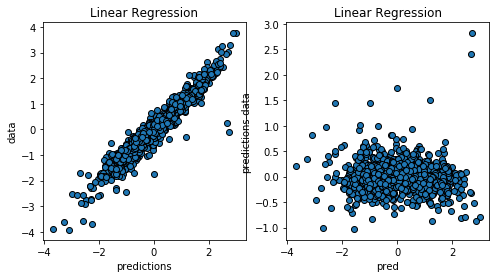

In [34]:
plot_scatter(predictions,y,'Linear Regression')

3. Lasso Regression

In [35]:
res=[] ; alpha_range = np.linspace(0.0005,0.003,10)
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
for a in alpha_range:
    La = Lasso(alpha=a) # find the best fitting alpha

    result_lasso = cross_val_score(La, X_select, y, \
                                   cv=kfold,scoring='neg_mean_absolute_error')     
    res.append(np.mean(-result_lasso)) 

best 0.0010555555555555557


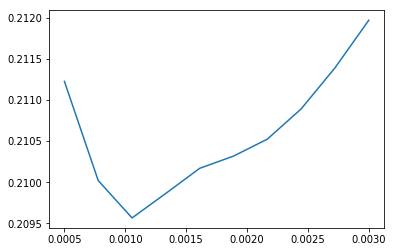

In [36]:
plt.plot(alpha_range,res)
print('best',alpha_range[res.index(min(res))])

In [37]:
# Lasso Regression
#X_select = X
La = LassoCV(alphas=[0.002]) # find the best fitting alpha
La.fit(X_select, y)
lassocv_alpha = La.alpha_
print('alpha', La.alpha_)
predictions = La.predict(X_select)

alpha 0.002


In [38]:
print_model_results(La,'Lasso Regression',kfold,y,predictions,X_select)

Mean_Absolute_Error 0.19250111980345747
Score 0.9162234650051401
Cross Validation Lasso Regression 0.21043565006837223


In [39]:
#(list(zip(model.coef_,X[features.index.values[1:]])))
lasso_feature = X_select.columns
print(len(lasso_feature[La.coef_ != 0]))
feature_new=lasso_feature[La.coef_ != 0]

76


use Lasso find new features (the coefficient not 0)

In [40]:
X_new = X[feature_new]

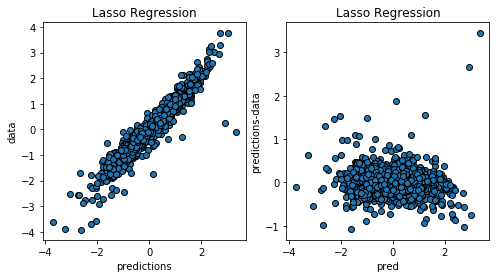

In [41]:
plot_scatter(predictions,y,'Lasso Regression')

4. Ridge Regression

In [42]:
# find the best alpha parameter 
from sklearn.linear_model import Ridge,RidgeCV
res=[] ; alpha_range=np.linspace(0.5,10,10)
for a in alpha_range:
    rr = Ridge(alpha=a)
    rr.fit(X_new, y) 
    result_rr = cross_val_score(rr, X_new, y, cv=kfold,scoring='neg_mean_absolute_error')
          
    res.append(np.mean(result_rr))

best 7.888888888888889


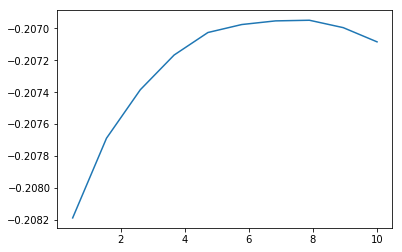

In [43]:
plt.plot(alpha_range,res)
print('best',alpha_range[res.index(max(res))])

In [44]:
rr = Ridge(alpha=[7])
rr.fit(X_new, y) 
#print(rr.alpha_)
predictions=rr.predict(X_new)

In [45]:
print_model_results(rr,'Ridge Regression',kfold,y,predictions,X_new)

Mean_Absolute_Error 0.19151330323777474
Score 0.9189362597837142
Cross Validation Ridge Regression 0.20695234939668197


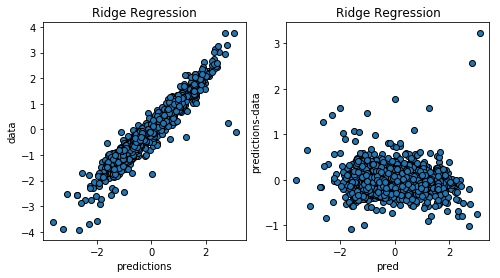

In [46]:
plot_scatter(predictions,y,'Ridge Regression')

5. Decision Tree & Random Forest

In [47]:
X_new.shape# = X[feature_new]

(1460, 76)

In [48]:
# Decision Tree & Random Forest
rf = RandomForestRegressor(n_estimators=200,random_state = 10)
# Fit model
rf.fit(X_new, y)
predictions = rf.predict(X_new)

In [49]:
print_model_results(rf,'RF Regression',kfold,y,predictions,X_new)

Mean_Absolute_Error 0.08626337472571637
Score 0.9835561604697706
Cross Validation RF Regression 0.23534125063692066


In [50]:
importances = list(rf.feature_importances_) ; feature_list = list(X_new.columns)
feature_importances = [(feature, importance) for feature, importance in \
                       zip(feature_list, importances)]
feature_importances = pd.DataFrame(feature_importances, columns=['feature','importance'])

In [51]:
feature_importances = feature_importances.sort_values(['importance'],\
                        ascending=False).reset_index(drop=True)

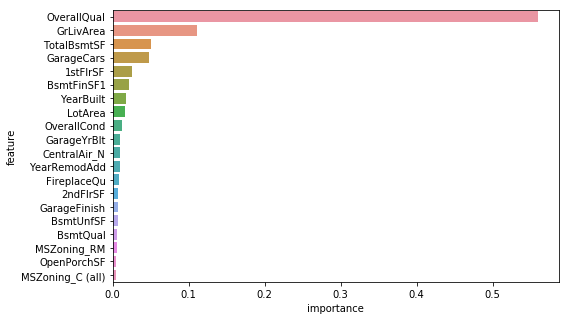

In [52]:
plt.subplots(figsize=(8, 5))
sns.barplot(y='feature', x='importance',data=feature_importances.iloc[:20])

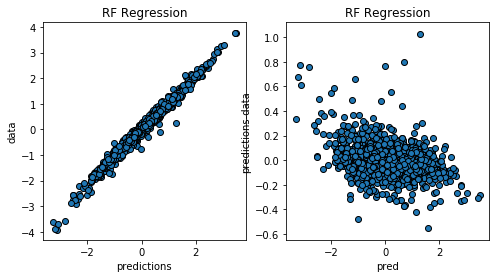

In [53]:
plot_scatter(predictions,y,'RF Regression')

6. XGBoost 

In [54]:
import xgboost

xgb = xgboost.XGBRegressor(n_estimators=200, learning_rate=0.08, gamma=0, subsample=0.75,\
                           colsample_bytree=1, max_depth=7)
xgb.fit(X_new,y)
predictions = xgb.predict(X_new)

In [55]:
#X_select=X_select[feature_importances.feature.values[:70]]

In [56]:
print_model_results(xgb,'XGB Regression',kfold,y,predictions,X_new)

Mean_Absolute_Error 0.023558088513472165
Score 0.9989575271734012
Cross Validation XGB Regression 0.21678335056500392


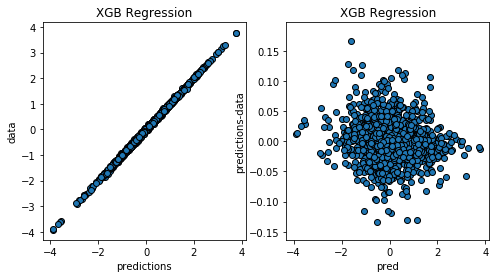

In [57]:
plot_scatter(predictions,y,'XGB Regression')

## Learning Curves

<module 'matplotlib.pyplot' from '/Users/hanzhang/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

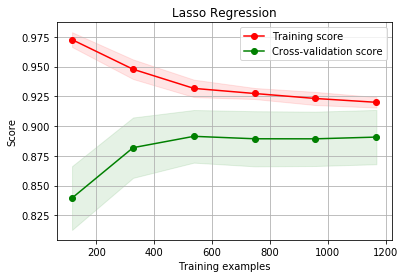

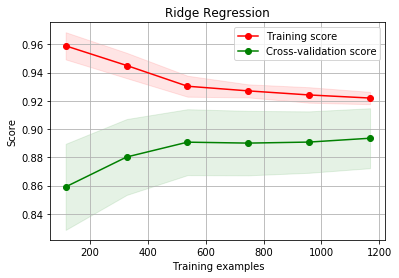

In [58]:
#from house_functions import * 
from sklearn.model_selection import ShuffleSplit

title = "Lasso Regression"
cv = ShuffleSplit(n_splits=8, test_size=0.2, random_state=0)
estimator = La
plot_learning_curve(estimator, title, X_new, y, cv=cv, n_jobs=10)

title = "Ridge Regression"
cv = ShuffleSplit(n_splits=8, test_size=0.2, random_state=0)
estimator = rr
plot_learning_curve(estimator, title, X_new, y, cv=cv, n_jobs=10)

<module 'matplotlib.pyplot' from '/Users/hanzhang/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

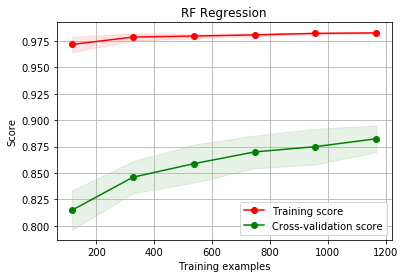

In [59]:
title = "RF Regression"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = rf
plot_learning_curve(estimator, title, X_new, y, cv=cv, n_jobs=10)

<module 'matplotlib.pyplot' from '/Users/hanzhang/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

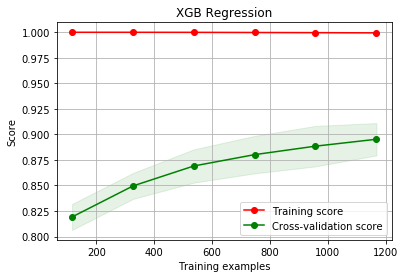

In [60]:
title = "XGB Regression"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = xgb
plot_learning_curve(estimator, title, X_new, y, cv=cv, n_jobs=10)

## Predictions

In [61]:
# Lasso 
#La = LassoCV(alphas=[0.002]) # find the best fitting alpha
#La.fit(X_new, y)
pred=rr.predict(test_X_std[feature_new])

In [62]:
Y_pred=yscaler.inverse_transform(pred)
Y_pred=np.expm1(Y_pred)
print(np.mean(Y_pred), np.mean(np.expm1(yscaler.inverse_transform(y))))

177460.13192885218 180921.19589041095


In [63]:
#print(np.mean(Y_pred), np.mean(np.expm1(yscaler.inverse_transform(y))))

In [64]:
name=test.Id
submission=pd.DataFrame(
    {'Id': name,
     'SalePrice': Y_pred
    })

print(len(submission['Id']))
submission.to_csv('submission.csv', index=False)

1459


Scored 0.1212